In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])

import csv
from scipy.fft import fft, fftfreq, fftshift

from scipy.stats import linregress
from tabulate import tabulate

In [2]:
data_index = 0
signal_freq_list = []
reference_freq_list = []

In [38]:
# info about the data
sig_name = 'NEGRES49.CSV'
ref_name = 'NEGRES50.CSV'
data_path = r'waveform_data_csv'

# importing the csv files
sig = csv.reader(open(f'{data_path}\{sig_name}', 'r'))
ref = csv.reader(open(f'{data_path}\{ref_name}', 'r'))
data_index = data_index + 1

# extracting the data from the csv files
sig_data = []
ref_data = []
for row in sig:
    sig_data.append(row)
for row in ref:
    ref_data.append(row)

# converting the data to numpy arrays
sig_data = np.array(sig_data)
ref_data = np.array(ref_data)

In [39]:
print(sig_data)
print(sig_data.shape)

[['in s' 'C1 in V']
 ['-3.00001E+00' '1.56282E-02']
 ['-2.99996E+00' '1.52162E-02']
 ...
 ['2.99986E+00' '2.78886E-02']
 ['2.99991E+00' '2.77895E-02']
 ['2.99996E+00' '2.77132E-02']]
(119049, 2)


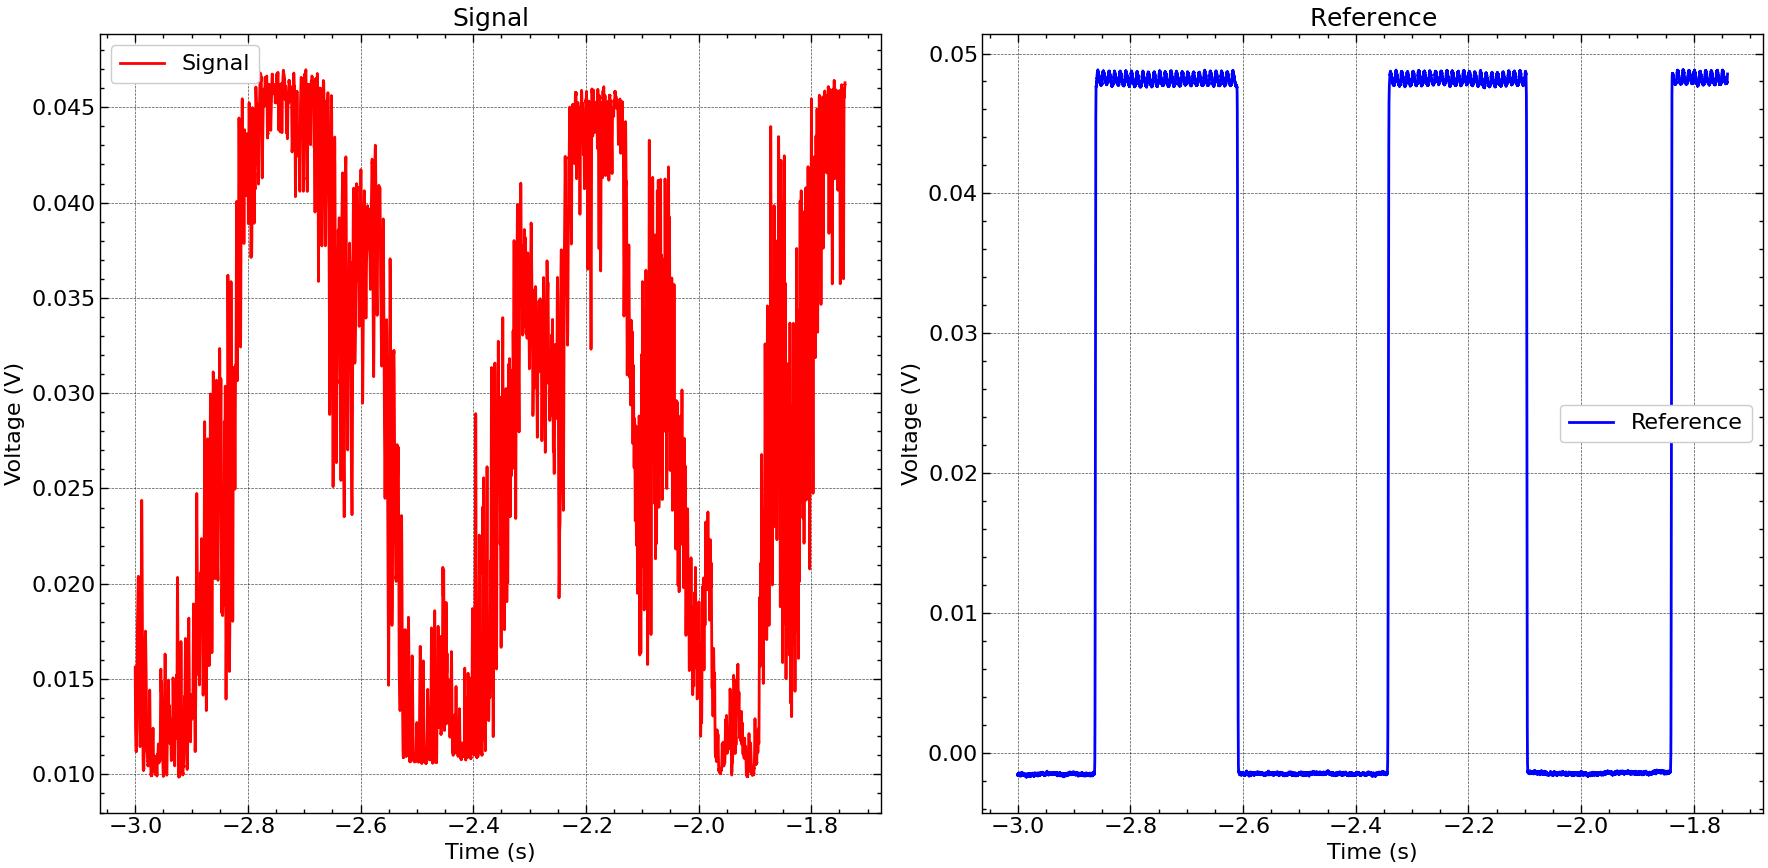

In [40]:
N_sample = 25000

sig_data = sig_data[1:N_sample,:].astype(float)
sig_data_plot = np.transpose(sig_data)
ref_data = ref_data[1:N_sample,:].astype(float)
ref_data_plot = np.transpose(ref_data)

plt.rcParams.update({'font.size': 14})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# Plot for Signal
ax1.plot(sig_data_plot[0], sig_data_plot[1], 'r', label='Signal', linewidth=2)  # Increase line width
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')
ax1.set_title(r'$\mathrm{Signal}$', fontsize=18, fontweight='bold')  # LaTeX formatted title
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)  

# Plot for Reference
ax2.plot(ref_data_plot[0], ref_data_plot[1], 'b', label='Reference', linewidth=2)  
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Voltage (V)')
ax2.set_title(r'$\mathrm{Reference}$', fontsize=18, fontweight='bold')  
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)  

plt.tight_layout()  
plt.savefig(f'plots/waveform_data_{data_index}.pdf', bbox_inches='tight')
plt.show()

In [41]:
def plot_fft(signal_data, reference_data):
    N = len(signal_data[0])
    T = signal_data[0][1] - signal_data[0][0]

    yf_signal = fft(signal_data[1])
    xf_signal = fftfreq(N, T)

    xf_signal = xf_signal[1:int(len(xf_signal)/50)]
    yf_signal = yf_signal[1:int(len(yf_signal)/50)]

    yf_reference = fft(reference_data[1])
    xf_reference = fftfreq(N, T)

    xf_reference = xf_reference[1:int(len(xf_reference)/50)]
    yf_reference = yf_reference[1:int(len(yf_reference)/50)]

    # FFTs side by side
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plotting signal FFT
    axs[0].plot(xf_signal, 1.0/N * np.abs(yf_signal), label='FFT of Signal')
    axs[0].set_xlabel('Frequency (Hz)')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_title('FFT of the Signal')

    # Marking dominant frequency for signal
    dominant_freq_signal = xf_signal[np.argmax(np.abs(yf_signal))]
    axs[0].plot(dominant_freq_signal, 1.0/N * np.abs(yf_signal)[np.argmax(np.abs(yf_signal))], 'ro')
    axs[0].legend([f'Dominant Frequency: {dominant_freq_signal:.2f} Hz'])

    # Plotting reference FFT
    axs[1].plot(xf_reference, 1.0/N * np.abs(yf_reference), label='FFT of Reference')
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Amplitude')
    axs[1].set_title('FFT of the Reference')

    # Marking dominant frequency for reference
    dominant_freq_reference = xf_reference[np.argmax(np.abs(yf_reference))]
    axs[1].plot(dominant_freq_reference, 1.0/N * np.abs(yf_reference)[np.argmax(np.abs(yf_reference))], 'ro')
    axs[1].legend([f'Dominant Frequency: {dominant_freq_reference:.2f} Hz'])

    plt.tight_layout()
    plt.savefig(f'plots/fft_{data_index}.pdf', bbox_inches='tight')
    plt.show()
    
    return dominant_freq_signal, dominant_freq_reference

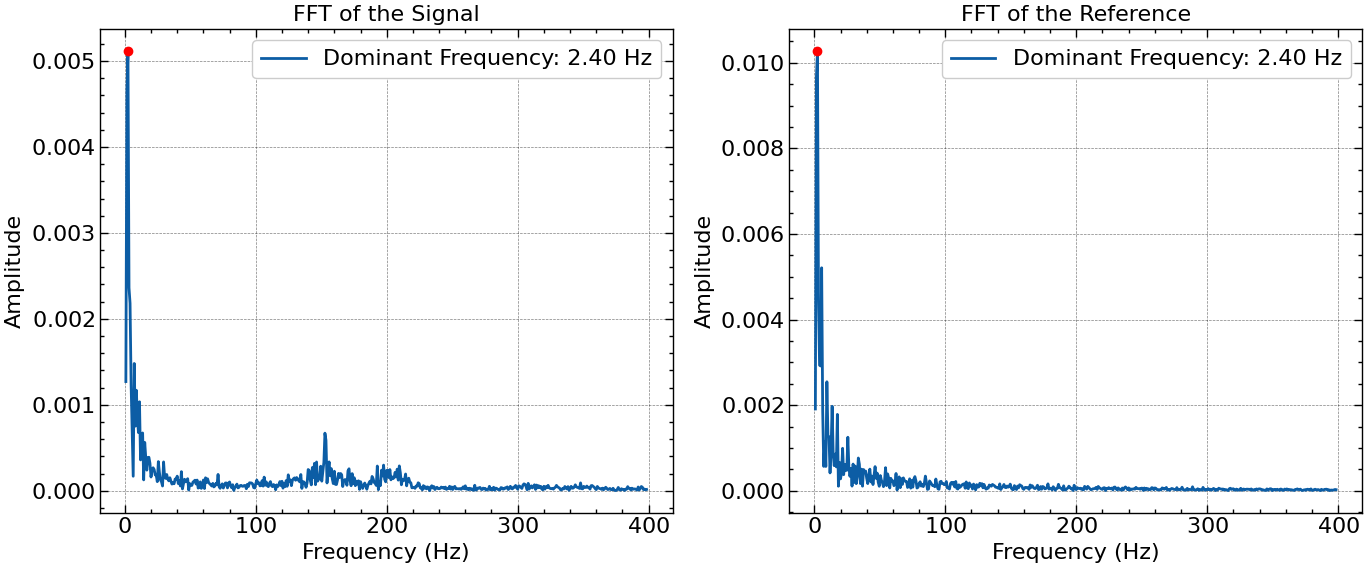

In [42]:
signal_freq, ref_freq = plot_fft(sig_data_plot,ref_data_plot)

In [43]:
print("\nFFT Frequencies:")
print("-------------------------")
print("|    Signal    |  Reference  |")
print("-------------------------")
print(f"|  {signal_freq:.2f} Hz  |  {ref_freq:.2f} Hz  |")
print("-------------------------")


FFT Frequencies:
-------------------------
|    Signal    |  Reference  |
-------------------------
|  2.40 Hz  |  2.40 Hz  |
-------------------------


In [44]:
signal_freq_list.append(signal_freq)
reference_freq_list.append(ref_freq)

In [45]:
signal_freq_array = np.array(signal_freq_list)
reference_freq_array = np.array(reference_freq_list)

# linear regression
slope, intercept, r_value, p_value, std_err = linregress(reference_freq_array, signal_freq_array)

# predicted values
predicted_signal_freq = slope * reference_freq_array + intercept
residuals = signal_freq_array - predicted_signal_freq
r_squared = r_value ** 2
mse = np.mean(residuals ** 2)

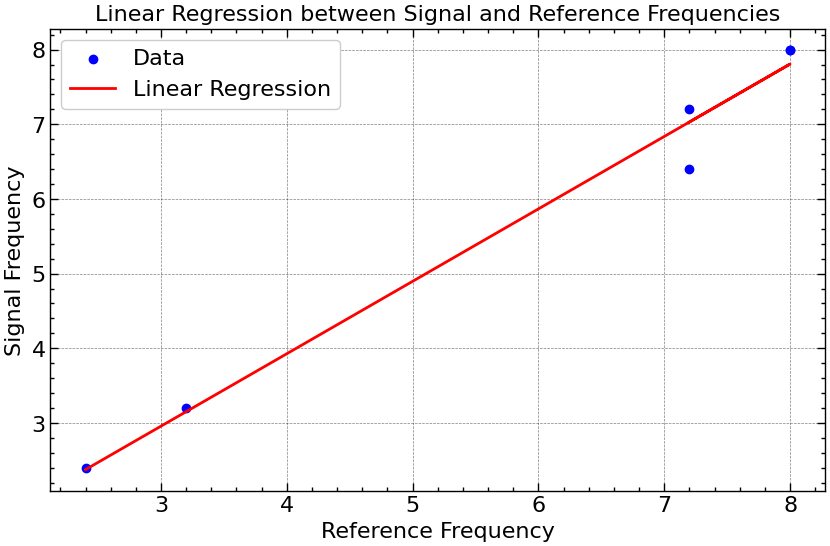

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(reference_freq_array, signal_freq_array, color='blue', label='Data')
plt.plot(reference_freq_array, predicted_signal_freq, color='red', label='Linear Regression')
plt.xlabel('Reference Frequency')
plt.ylabel('Signal Frequency')
plt.title('Linear Regression between Signal and Reference Frequencies')
plt.legend()
plt.grid(True)
plt.savefig('plots/linear_regression_data.pdf', bbox_inches='tight')
plt.show()

In [47]:
# summary table
table = [["Slope", slope],
         ["Intercept", intercept],
         ["R-squared", r_squared],
         ["p-value", p_value],
         ["Standard Error", std_err],
         ["Mean Squared Error", mse]]

print(tabulate(table, headers=["Metric", "Value"], tablefmt="grid"))

+--------------------+-------------+
| Metric             |       Value |
+====================+=============+
| Slope              | 0.969697    |
+--------------------+-------------+
| Intercept          | 0.0484868   |
+--------------------+-------------+
| R-squared          | 0.983355    |
+--------------------+-------------+
| p-value            | 0.000104482 |
+--------------------+-------------+
| Standard Error     | 0.0630808   |
+--------------------+-------------+
| Mean Squared Error | 0.0840471   |
+--------------------+-------------+
